Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.


### This will stop when we writ 

In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labeled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [3]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Attempting to download: notMNIST_large.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified .\notMNIST_large.tar.gz
Attempting to download: notMNIST_small.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified .\notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labeled A through J.

In [4]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

Extracting data for .\notMNIST_large. This may take a while. Please wait.
['.\\notMNIST_large\\A', '.\\notMNIST_large\\B', '.\\notMNIST_large\\C', '.\\notMNIST_large\\D', '.\\notMNIST_large\\E', '.\\notMNIST_large\\F', '.\\notMNIST_large\\G', '.\\notMNIST_large\\H', '.\\notMNIST_large\\I', '.\\notMNIST_large\\J']
Extracting data for .\notMNIST_small. This may take a while. Please wait.
['.\\notMNIST_small\\A', '.\\notMNIST_small\\B', '.\\notMNIST_small\\C', '.\\notMNIST_small\\D', '.\\notMNIST_small\\E', '.\\notMNIST_small\\F', '.\\notMNIST_small\\G', '.\\notMNIST_small\\H', '.\\notMNIST_small\\I', '.\\notMNIST_small\\J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [5]:
    # figure out how to list the directory for A and print the first one or two files in there
    #plt.imshow(letter_set[1])

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [6]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (imageio.imread(image_file).astype(float) - 
                    pixel_depth / 2) / (pixel_depth/2)
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except (IOError, ValueError) as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

Pickling .\notMNIST_large\A.pickle.
.\notMNIST_large\A
Could not read: .\notMNIST_large\A\RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Could not read: .\notMNIST_large\A\SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Could not read: .\notMNIST_large\A\Um9tYW5hIEJvbGQucGZi.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Full dataset tensor: (52909, 28, 28)
Mean: -0.2565
Standard deviation: 0.886241
Pickling .\notMNIST_large\B.pickle.
.\notMNIST_large\B
Could not read: .\notMNIST_large\B\TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Full dataset tensor: (52911, 28, 28)
Mean: -0.0151261
Standard deviation: 0.908982
Pickling .\notMNIST_large\C.pickle.
.\notMNIST_large\C
Full dataset tensor: (52912, 28, 28)
Mea

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

size of letter_set 52909
length of images 25


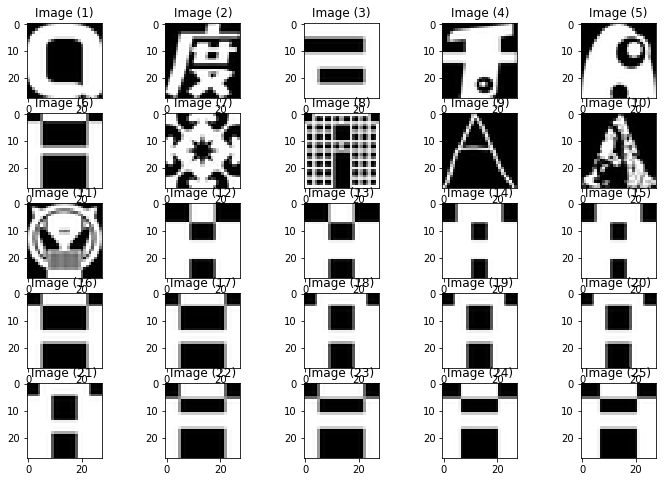

In [7]:
samplefile = ".\\notMNIST_large\\A.pickle"

def show_images(images, cols=1, titles=None):
    """Displays a list of images
    from https://gist.github.com/soply/f3eec2e79c165e39c9d540e916142ae1
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None) or (len(images)==len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    print("length of images %d" % len(images))
    for n, (image, title) in enumerate(zip(images, titles)):
        #a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n+1)
        a = fig.add_subplot(np.ceil(n_images/float(cols)), cols, n+1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    #fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    fig.set_size_inches(np.array(fig.get_size_inches()) * 2)
    #fig.set_size_inches(np.array(n_images) *3)
    plt.show()
        
    
    

try:
    with open(samplefile, 'rb') as f:
        letter_set = pickle.load(f)

    print("size of letter_set", len(letter_set))
    
    show_images(letter_set[1:26],5)
                          
        
except Exception as e:
    print('Unable to process data from', samplefile, ':', e)


---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.
### Key Section
This part is where we specify the size of the train, test, and validation sets we will use

In [8]:
# these are huge and take about 5+ minutes to run the training on my local PC            
#train_size = 400000 #200000
#valid_size = 80000  #10000
train_size = 200000
valid_size = 10000
test_size = 10000

In [9]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            


valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [10]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

In [11]:
import random
sample_set = random.sample(range(0,len(train_dataset)), 20) 
sample_set

[72549,
 175234,
 30719,
 58189,
 79573,
 112787,
 84063,
 171602,
 36690,
 81090,
 129260,
 146404,
 7761,
 47632,
 60344,
 122835,
 170803,
 182169,
 98997,
 54255]

length of images 20


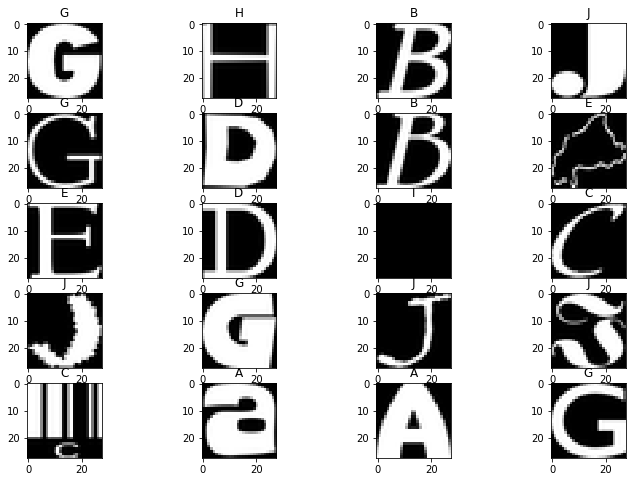

In [12]:
sample_set = random.sample(range(0,len(train_dataset)), 20) 
show_images(train_dataset[sample_set],4, list(map(chr, [x+65 for x in train_labels[sample_set]])))

length of images 20


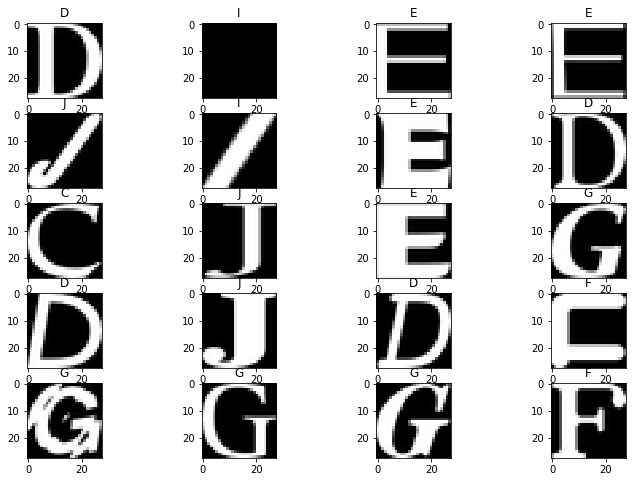

In [13]:
sample_set = random.sample(range(0,len(test_dataset)), 20) 
show_images(test_dataset[sample_set],4, list(map(chr, [x+65 for x in test_labels[sample_set]])))

length of images 20


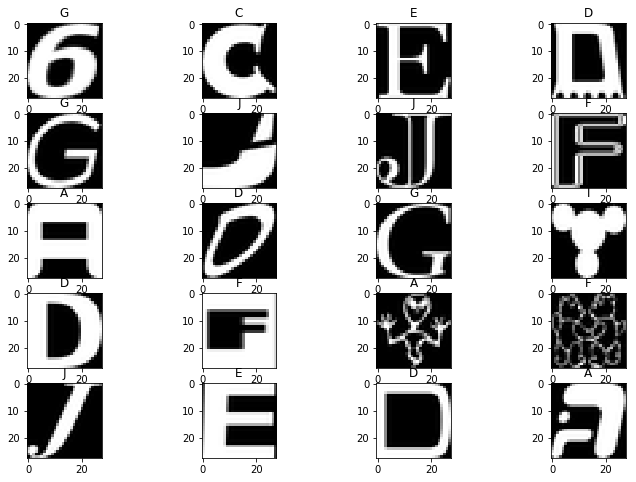

In [14]:
sample_set = random.sample(range(0,len(valid_dataset)), 20) 
show_images(valid_dataset[sample_set],4, list(map(chr, [x+65 for x in valid_labels[sample_set]])))

---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [15]:
# taken from Discussion Board
# https://discussions.udacity.com/t/assignment-1-problem-5/45657/10
#train_dataset.flags.writeable=False
test_dataset.flags.writeable=False
dup_table={}

for idx,img in enumerate(test_dataset):
    h = hash(bytes(img.data))
    if h in dup_table and (train_dataset[dup_table[h]].data == img.data):
        print ('Test image %d is in the training set' % idx)

In [16]:
# another check - somhow this shows results, the other doesn...

import time
def check_overlaps(images1, images2):
    images1.flags.writeable=False
    images2.flags.writeable=False
    start = time.clock()
    hash1 = set([hash(bytes(image1.data)) for image1 in images1])
    hash2 = set([hash(bytes(image2.data)) for image2 in images2])
    all_overlaps = set.intersection(hash1, hash2)
    return all_overlaps, time.clock()-start

r, execTime = check_overlaps(train_dataset, test_dataset)    
print ("# overlaps between training and test sets:", len(r), "execution time:", execTime)
r, execTime = check_overlaps(train_dataset, valid_dataset)   
print ("# overlaps between training and validation sets:", len(r), "execution time:", execTime )
r, execTime = check_overlaps(valid_dataset, test_dataset) 
print ("# overlaps between validation and test sets:", len(r), "execution time:", execTime)
r

# overlaps between training and test sets: 1153 execution time: 0.4383946595929354
# overlaps between training and validation sets: 953 execution time: 0.435613522659671
# overlaps between validation and test sets: 55 execution time: 0.040832268697763796


{-8816893259461793903,
 -8509176258463497697,
 -8393281239318227803,
 -7071028645719332165,
 -6614347871005062357,
 -5743547368531997299,
 -4728472661466520152,
 -4666165640500258248,
 -4101608235360381465,
 -3966961703903560498,
 -3894579104696955520,
 -3561331360415885310,
 -2085818419473659684,
 -1804570848460523405,
 -1554871499283669854,
 -1366389669952873523,
 -1328745458272997024,
 -1300289062494768683,
 -1169628685922297714,
 -733596329402199176,
 -690459863160930208,
 -389930694713561308,
 -312589719440641667,
 687103060479128207,
 818611807046999658,
 1043484052809109324,
 1226655965834098444,
 1235498647771684174,
 1462521985202527782,
 1629184789592862834,
 1655224546092082356,
 1794840337499374972,
 2024304211333954551,
 2557258349935282874,
 2778194411429139737,
 2911525765331537093,
 3346673249193783378,
 3743747978854559502,
 4158890147608372016,
 4424297011324438572,
 4446345366230653087,
 4662337810343864763,
 4690528386181435502,
 4726991140889441968,
 51748315015852

2 15
length of images 2


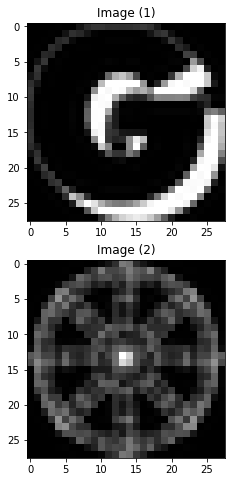

3 8
length of images 2


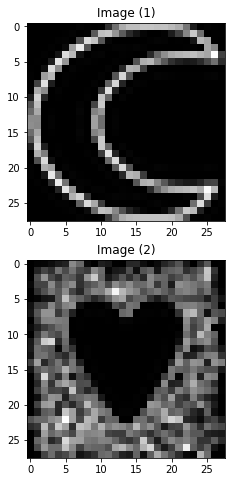

3 15
length of images 2


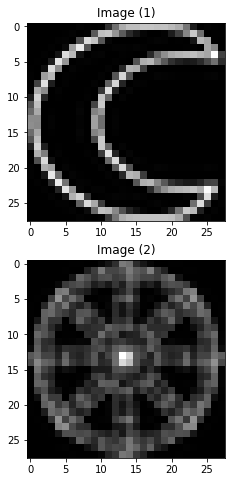

7 24
length of images 2


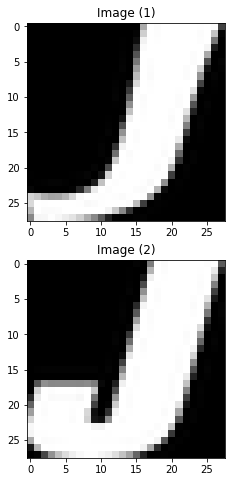

8 15
length of images 2


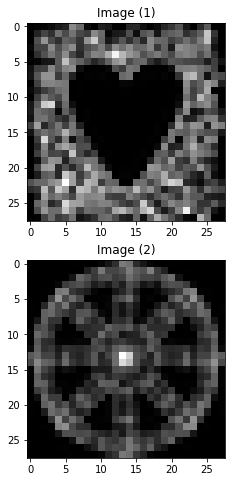

15 18
length of images 2


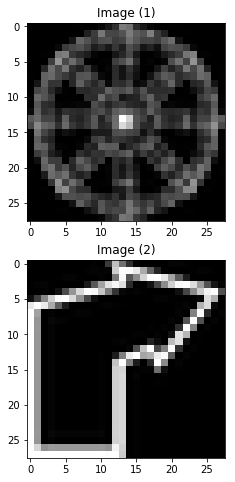

15 19
length of images 2


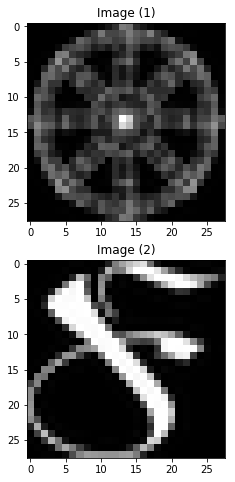

7


In [17]:
# I can't remember where I found this one, but think this is the best
#
#
dup = 0

full_dataset = np.concatenate((train_dataset, test_dataset, valid_dataset), axis=0)


for i in range(full_dataset.shape[1]):
    # changed to one sided search
    for j in range(i, full_dataset.shape[1]):
        diff = full_dataset[i,:,:] - full_dataset[j,:,:]
        chisq = np.sum(np.power(diff, 2))/784
        if i != j and chisq < 0.6:
            print(i,j)
            show_images([full_dataset[i], full_dataset[j]])
            dup += 1
print(dup)

## Save Datasets

Finally, let's save the data for later reuse:

In [18]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [19]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800506
